In [304]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import openaq
import warnings
warnings.simplefilter('ignore')

In [199]:
api = openaq.OpenAQ()

In [321]:
def get_data(param):
    date_from = '2018-8-1'
    date_to = '2018-11-1'
    res = api.measurements(city='San Francisco-Oakland-Fremont', 
                           location='Redwood City',
                           parameter=param, 
                           value_from=0,
                           date_from=date_from, 
                           date_to=date_to, 
                           limit=10000, 
                           df=True)
    df = res.groupby('location')
    df = df.resample('1h').mean()
    return df

In [322]:
dfs = []
params = ['pm25', 'no2', 'co']
for param in params:
    df = get_data(param).rename({'value': param}, axis='columns')
    dfs.append(df)
res = pd.concat(dfs, axis=1)

In [292]:
res.head()

coordinates.latitude  coordinates.longitude  \
location     date.local                                                         
Redwood City 2018-09-06 06:00:00               37.4828              -122.2022   
             2018-09-06 07:00:00               37.4828              -122.2022   
             2018-09-06 08:00:00               37.4828              -122.2022   
             2018-09-06 09:00:00               37.4828              -122.2022   
             2018-09-06 10:00:00               37.4828              -122.2022   

                                  pm25  coordinates.latitude  \
location     date.local                                        
Redwood City 2018-09-06 06:00:00  11.0               37.4828   
             2018-09-06 07:00:00  12.0               37.4828   
             2018-09-06 08:00:00  12.0               37.4828   
             2018-09-06 09:00:00  18.0               37.4828   
             2018-09-06 10:00:00  17.0               37.4828   

                                  coordinates.longitude    no2  \
location     date.local                                          
Redwood City 2018-09-06 06:00:00              -122.2022  0.011   
             2018-09-06 07:00:00              -122.2022  0.010   
             2018-09-06 08:00:00              -122.2022  0.007   
             2018-09-06 09:00:00              -122.2022  0.008   
             2018-09-06 10:00:00              -122.2022  0.012   

                                  coordinates.latitude  coordinates.longitude  \
location     date.local                                                         
Redwood City 2018-09-06 06:00:00               37.4828              -122.2022   
             2018-09-06 07:00:00               37.4828              -122.2022   
             2018-09-06 08:00:00               37.4828              -122.2022   
             2018-09-06 09:00:00               37.4828              -122.2022   
             2018-09-06 10:00:00               37.4828              -122.2022   

                                    co  
location     date.local                 
Redwood City 2018-09-06 06:00:00  0.27  
             2018-09-06 07:00:00  0.24  
             2018-09-06 08:00:00  0.22  
             2018-09-06 09:00:00  0.26  
             2018-09-06 10:00:00  0.28

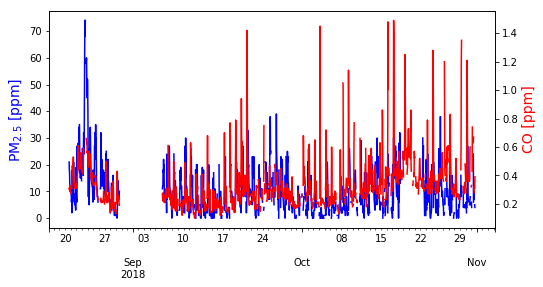

In [332]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

for g, df in res.groupby('location'):
    df = df.loc['Redwood City', :]
    df.index = pd.to_datetime(df.index)
    df.plot(y='pm25', color='b', ax=ax)
    ax.set_ylabel('PM$_{2.5}$ [ppm]', color='b', fontsize=14)

    df.plot(y='co', color='r', secondary_y=True, ax=ax)
    plt.ylabel('CO [ppm]', color='r', fontsize=14)
    
    ax.legend().set_visible(False)
    ax.set_xlabel('')

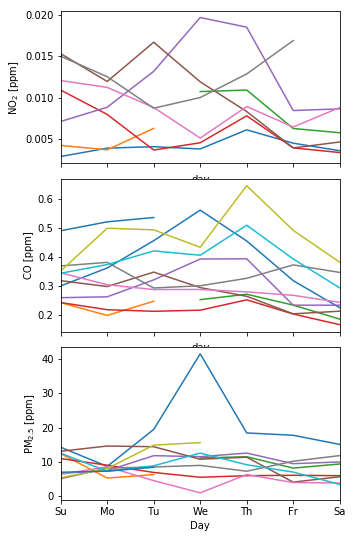

In [346]:
fig, axes = plt.subplots(3, 1, figsize=(5, 9))
ax = axes[0]
for g, df2 in df.groupby(pd.TimeGrouper('W')):
    df2['day'] = df2.index.dayofweek

    df2 = df2.groupby(pd.TimeGrouper('D')).mean()
    df2.plot(x='day', y='no2', ax=ax, legend=g)

    ax.set_xlim([0, 6])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('NO$_2$ [ppm]')
    ax.legend().set_visible(False)
    
ax = axes[1]
for g, df2 in df.groupby(pd.TimeGrouper('W')):
    df2['day'] = df2.index.dayofweek

    df2 = df2.groupby(pd.TimeGrouper('D')).mean()
    df2.plot(x='day', y='co', ax=ax, legend=g)

    ax.set_xlim([0, 6])
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_ylabel('CO [ppm]')
    ax.legend().set_visible(False)
    
ax = axes[2]
for g, df2 in df.groupby(pd.TimeGrouper('W')):
    df2['day'] = df2.index.dayofweek

    df2 = df2.groupby(pd.TimeGrouper('D')).mean()
    df2.plot(x='day', y='pm25', ax=ax, legend=g)

    ax.set_xlim([0, 6])
    ax.set_xticklabels(['Su', 'Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa'])
    ax.set_xlabel('Day')
    ax.set_ylabel('PM$_{2.5}$ [ppm]')
    ax.legend().set_visible(False)
    
plt.subplots_adjust(hspace=0.1)

In [274]:
weather = pd.read_csv('data/USC00047767.csv')
weather = weather.set_index(pd.to_datetime(weather['MM/DD/YYYY']))

In [275]:
weather = weather.resample('1h').mean().ffill()
print(weather.index.min(), weather.index.max())

1958-12-09 00:00:00 2018-10-31 00:00:00


In [294]:
mask = df.loc['Redwood City', :].index
weather = weather.loc[mask]

In [295]:
weather.index.name = 'date'
df.index.name = 'date'

In [297]:
df = pd.concat([df.loc['Redwood City', :], weather], axis=1)
df = df.dropna()

In [314]:
corr = df[['pm25', 'co', 'no2', 'TMIN', 'TMAX', 'PRCP']].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

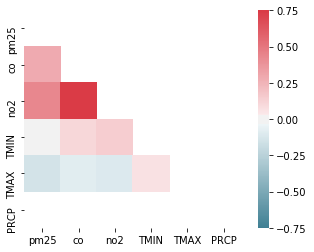

In [315]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, mask=mask, vmin=-0.75, vmax=0.75, center=0, square=True)

Text(0, 0.5, 'Precipitation [mm]')

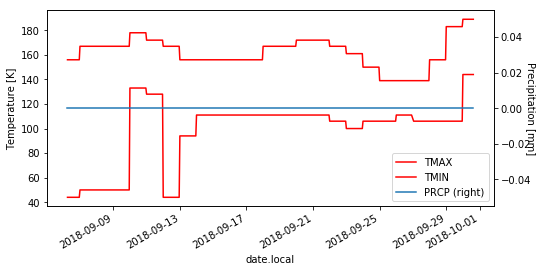

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
df.plot(y=['TMAX', 'TMIN'], color='r', ax=ax)
ax.set_ylabel('Temperature [K]')
df.plot(y='PRCP', secondary_y=True, ax=ax)
plt.ylabel('Precipitation [mm]', rotation=-90)